# Project 4 - "I need a vacation, but where should I go?"

## Import Libraries

In [ ]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Data lists for scraping
from project4data import cities, countries
from webscrape import country

# Scraping
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys 
import time
import requests
from bs4 import BeautifulSoup

# MongoDB
from pymongo import MongoClient

# NLP cleaning
from cleaning import clean_article

# Vectorising
import copy 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modelling & Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# PCA
from sklearn.decomposition import PCA

# Recommender Engine
from recommender import recommendation, return_countries

---

## Scrape article data from NYT

In [ ]:
# Webscrape each article and append to list of articles
articles = []

for city in cities:
    
    # Use selenium to access each article for a different city
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver

    # Open webpage
    driver = webdriver.Chrome(chromedriver)
    driver.get("https://www.nytimes.com/column/36-hours")
    time.sleep(2)

    # Click on search bar 
    element = driver.find_element_by_class_name("css-3q005l")
    element.click()
    time.sleep(2)

    # Click on search bar 
    element = driver.find_element_by_class_name("css-wm4t3d")
    element.click()
    time.sleep(2)

    # Enter in city from list 
    element = driver.find_element_by_xpath(".//div/input")
    element.send_keys(city)
    time.sleep(2)

    # Different cities need a different click function
    if city in country:
        element = driver.find_element_by_xpath("//a[contains(@href, 'hours')]")
        element.click()
        time.sleep(2)
        
    
    else:
        element = driver.find_element_by_class_name("highlighted")
        element.click()
        time.sleep(2)

    # Use Beautiful Soup to parse the html
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    paragraphs = soup.find_all(class_="listy_body")
    article_clean = " ".join(["".join(x.text) for x in paragraphs])
    
    if article_clean == '':
        full_article = soup.find_all(class_="story-body-text story-content")
        article_clean2 = " ".join(["".join(x.text) for x in full_article])
        
        
        if article_clean2 == '':
            full_article2 = soup.find_all(class_="css-1ygdjhk evys1bk0")
            article_clean3 = " ".join(["".join(x.text) for x in full_article2])
            articles.append(article_clean3)   
            print(city, ': Yes')
            
        else:
            print(city, ': Yes')
            articles.append(article_clean2)
    else:
        print(city, ': Yes')
        articles.append(article_clean)
    
    driver.close()

---

## Put data into MongoDB

In [166]:
# Create dictionary for each: _id, City, Country, Article
mongo_list = []
for i in range(len(articles)):
    mongo_list.append({'_id': i+1, 'City':cities[i], 'Country': countries[i], 'Article': articles[i]})

In [32]:
# Create and add full article data into MongoDB
client = MongoClient()
db = client['project4_fletcher']
collection = db['travel_articles']
#collection.insert_many(mongo_list)


In [48]:
# Test
cursor = list(db.travel_articles.find({'_id': 1}, {'_id':1, 'City':1, 'Article':1}))
cursor

[{'_id': 1,
  'City': 'Aarhus',
  'Article': '\nSmall and scholarly, Aarhus has an easygoing, college-town atmosphere – about one in seven residents is a university student. But the range of top-notch cultural institutions rivals that of many larger cities. A 2017 European Capital of Culture, Denmark’s second-largest city is sprouting new architectural landmarks and repurposed cultural complexes like wildflowers. An ongoing renovation of the old harbor is producing new spaces for design, drinking and dining. And the vibrant, walkable city center brims with discoveries high and low, from astounding rooftop artwork to cozy holes-in-the-wall — all less than three hours by train from Copenhagen.\n \n1) 3:30 P.M. Art Immersion Acquaint yourself with the city atop\xa0ARoS, Aarhus’s 10-story art museum where a spectacular circular walking path encased in rainbow-hued glass crowns the roof. This eminently Instagrammable installation, “Your Rainbow Panorama,” by Olafur Eliasson, lets viewers li

---

## Clean text data

In [36]:
# Clean all articles from scraped data
clean_articles = []

for city_id in range(1,182):
    art = list(db.travel_articles.find({'_id': city_id}, {'_id':0, 'Article':1}))
    for obj in art:
        clean_articles.append(clean_article(str(obj['Article']))) 

---

## Count Vectorize

In [53]:
# Make a copy of the articles for count vectorising & tfidf
cv_articles = copy.deepcopy(clean_articles) 
tf_articles = copy.deepcopy(clean_articles)

In [54]:
cv = CountVectorizer(min_df=0.15, max_df=0.9)
cv_X = cv.fit_transform(cv_articles)

In [55]:
cv_array = pd.DataFrame(cv_X.toarray(), index=cities, columns=cv.get_feature_names())

In [56]:
cv_array.head()

,access,accompany,acr,across,act,ad,addit,adv,afford,afternoon,...,wood,wor,work,world,would,wrap,writ,year,yet,young
Aarhus,0,0,0,1,0,1,0,0,0,0,...,3,0,3,0,0,2,1,2,0,0
Amsterdam,0,0,0,0,1,0,0,1,3,1,...,1,2,1,1,0,1,0,7,0,4
Anguilla,0,0,2,1,0,0,0,0,1,2,...,1,0,0,0,1,0,0,4,1,0
Antwerp,0,2,1,3,0,0,0,0,0,1,...,1,0,5,0,0,0,0,5,0,2
Aruba,1,0,0,0,3,1,1,0,0,0,...,1,2,3,0,0,0,0,3,0,0


---

## TF-IDF

In [57]:
tfidf = TfidfVectorizer(min_df=0.1, max_df=0.9, ngram_range=(1,3))
tf_X = tfidf.fit_transform(tf_articles)

In [58]:
tf_array = pd.DataFrame(tf_X.toarray(), index=cities, columns=tfidf.get_feature_names())

In [59]:
tf_array.head()

,abound,acc,access,accompany,accord,acr,across,act,ad,addit,...,would,wrap,writ,ye,year,year ago,year old,yellow,yet,young
Aarhus,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.023527,0.000000,0.035388,0.000000,...,0.000000,0.070101,0.034721,0.000000,0.032937,0.000000,0.034721,0.000000,0.000000,0.000000
Amsterdam,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.033623,0.000000,0.000000,...,0.000000,0.040468,0.000000,0.000000,0.133100,0.043412,0.080175,0.000000,0.000000,0.126802
Anguilla,0.0,0.0,0.000000,0.000000,0.0,0.091189,0.029130,0.000000,0.000000,0.000000,...,0.039684,0.000000,0.000000,0.054515,0.081564,0.046555,0.042990,0.000000,0.045133,0.000000
Antwerp,0.0,0.0,0.000000,0.086251,0.0,0.039017,0.074782,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.087245,0.039838,0.036788,0.044786,0.000000,0.058182
Aruba,0.0,0.0,0.035751,0.000000,0.0,0.000000,0.000000,0.082187,0.033290,0.035001,...,0.000000,0.000000,0.000000,0.000000,0.046477,0.000000,0.000000,0.000000,0.000000,0.000000


---

## Topic Modelling

### LSA and TFIDF

In [62]:
tf_array.shape

(181, 1185)

In [63]:
lsa = TruncatedSVD(5) 
doc_topic = lsa.fit_transform(tf_array) 
lsa.explained_variance_ratio_.round(3)

array([0.001, 0.022, 0.017, 0.015, 0.014])

In [64]:
# Create dataframe of each word and weighting of word per article
topic_word = pd.DataFrame(lsa.components_.round(3),
             columns = tfidf.get_feature_names())
topic_word

,abound,acc,access,accompany,accord,acr,across,act,ad,addit,...,would,wrap,writ,ye,year,year ago,year old,yellow,yet,young
0,0.014,0.013,0.018,0.017,0.015,0.023,0.049,0.035,0.020,0.018,...,0.025,0.021,0.023,0.016,0.090,0.020,0.026,0.016,0.024,0.040
1,0.026,-0.027,-0.016,-0.020,0.032,0.022,-0.029,0.013,0.001,-0.005,...,0.026,0.016,-0.005,0.002,-0.066,0.000,-0.024,-0.014,0.026,0.007
2,0.010,0.017,0.020,0.007,-0.029,0.026,0.009,-0.001,0.033,0.006,...,0.019,0.004,-0.005,0.023,0.021,0.030,0.024,0.004,0.029,-0.058
3,-0.020,-0.024,0.026,-0.020,-0.026,0.055,0.044,0.008,0.034,0.013,...,-0.004,-0.036,-0.024,0.012,0.032,-0.020,0.041,-0.009,0.011,-0.051
4,0.015,0.011,-0.016,0.006,0.058,-0.016,-0.021,-0.033,0.015,0.017,...,-0.010,0.020,0.006,-0.018,0.066,0.003,-0.018,0.020,0.019,0.087


In [65]:
# Function to show most important words in different topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    
    '''Displays topics and word in order of importance for each topic
    Inputs: Model being used for analysis, topic names, number of words to 
    present for each category'''
    
    for idx, topic in enumerate(model.components_):
        if not topic_names or not topic_names[idx]:
            print("\nTopic ", idx)
        else:
            print("\nTopic: '",topic_names[idx],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [66]:
display_topics(lsa, tfidf.get_feature_names(),15)


Topic  0
op, art, room, two, off, year, start, century, shop, build, bar, tak, design, win, night

Topic  1
start, island, get, doll, sand, tax, beach, high, way, night, plac, fly, rat, find, trop

Topic  2
island, ston, sand, beach, fish, sea, wat, coast, sun, coconut, century, hotel, whit, win, gard

Topic  3
op, island, downtown, nat, art, mil, tap, harb, wat, rent, foc, new, chef, stor, expl

Topic  4
island, op, design, op last, two without, styl, flight, district, cool, doubl, doll, start, young, search, jean


In [67]:
# Create dataframe of topic array (Vt in equation)
Vt = pd.DataFrame(doc_topic.round(5),
             index = cities)
Vt.head()

,0,1,2,3,4
Aarhus,0.56633,-0.26214,-0.00236,0.12278,-0.04412
Amsterdam,0.54429,-0.19126,-0.12014,0.12707,0.00567
Anguilla,0.49124,0.18357,0.17091,0.13485,0.06951
Antwerp,0.59700,-0.23662,-0.07741,0.08089,0.02963
Aruba,0.43181,0.17171,0.40107,0.27740,0.13813


In [68]:
# Check similarity between articles
cos_sim = pd.DataFrame(cosine_similarity(Vt).round(), index=cities, columns=cities)
cos_sim.head()

,Aarhus,Amsterdam,Anguilla,Antwerp,Aruba,Athens,Auckland,Bali,Bangalore,Bangkok,...,Verona,Vienna,Vientiane,Vieques,Vilnius,Warsaw,Yangon,Zagreb,Zanzibar,Zurich
Aarhus,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Amsterdam,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Anguilla,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Antwerp,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Aruba,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


**Observations**:
- A lot of similarity between a lot of cities - possibly due to the way each article is structured?

### NMF and TFIDF - [Best]

In [69]:
nmf_model = NMF(6, random_state=27) # Try dfferent topic numbers 
doc_topic_nmf_tfidf = nmf_model.fit_transform(tf_array)

In [70]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), #.components_ gets it out of NMF              
             columns =tfidf.get_feature_names())
topic_word

,abound,acc,access,accompany,accord,acr,across,act,ad,addit,...,would,wrap,writ,ye,year,year ago,year old,yellow,yet,young
0,0.014,0.007,0.035,0.000,0.000,0.031,0.069,0.094,0.009,0.015,...,0.059,0.024,0.034,0.028,0.036,0.000,0.028,0.000,0.010,0.000
1,0.037,0.001,0.000,0.005,0.078,0.003,0.008,0.030,0.000,0.019,...,0.030,0.038,0.031,0.000,0.069,0.000,0.000,0.018,0.024,0.124
2,0.024,0.005,0.031,0.007,0.005,0.072,0.044,0.024,0.069,0.026,...,0.046,0.016,0.003,0.036,0.100,0.033,0.043,0.004,0.072,0.000
3,0.000,0.008,0.029,0.020,0.000,0.032,0.109,0.031,0.040,0.025,...,0.000,0.000,0.010,0.013,0.181,0.012,0.064,0.025,0.009,0.035
4,0.029,0.063,0.027,0.036,0.008,0.000,0.028,0.021,0.004,0.026,...,0.025,0.037,0.049,0.000,0.105,0.007,0.015,0.024,0.014,0.040
5,0.000,0.002,0.005,0.047,0.014,0.031,0.052,0.016,0.026,0.007,...,0.012,0.034,0.020,0.045,0.099,0.096,0.023,0.035,0.052,0.071


In [71]:
display_topics(nmf_model, tfidf.get_feature_names(), 15)


Topic  0
town, tour, visit, tak, best, get, neighb, way, build, del, room, us, walk, also, hist

Topic  1
start, doll, get, night, fly, find, club, tax, look, off, high, search, design, district, flight

Topic  2
island, sand, beach, wat, fish, op, sea, hotel, off, tour, nat, coast, along, resort, mil

Topic  3
op, new, art, design, shop, year, exhibit, spac, caf, work, cre, bar, form, room, rec

Topic  4
win, century, ston, two without, without, two, bar, hous, whit, doubl, contemp, cours, chees, mediev, room

Topic  5
templ, japanes, colon, shop, tea, ric, century, ant, flo, around, room, wom, ind, back, new


In [72]:
# Create dictionary of City and most prominent topic
city_topic_nmf_tfidf = dict(zip(cities, np.argmax(doc_topic_nmf_tfidf, axis=1)))

In [ ]:
# Check each topic to observe cities
for number in range(0,7):
    for k,v in city_topic_nmf_tfidf.items():
        if v == number:
            print(f"Topic: {number}, {k}")

In [82]:
# Check prevelance of topic for each city
H = pd.DataFrame(doc_topic_nmf_tfidf.round(5),
             index = cities)
H.head(5)

,0,1,2,3,4,5
Aarhus,0.05301,0.00000,0.00988,0.33653,0.09645,0.00000
Amsterdam,0.03170,0.06501,0.00000,0.36926,0.00000,0.00000
Anguilla,0.03968,0.07101,0.33514,0.00529,0.02124,0.01897
Antwerp,0.01016,0.03953,0.00000,0.34491,0.08747,0.04812
Aruba,0.00000,0.00000,0.51555,0.00000,0.00000,0.00000


In [40]:
cos_sim_nmf = pd.DataFrame(cosine_similarity(H).round(), index=cities, columns=cities)
cos_sim_nmf.head()

,Aarhus,Amsterdam,Anguilla,Antwerp,Aruba,Athens,Auckland,Bali,Bangalore,Bangkok,...,Verona,Vienna,Vientiane,Vieques,Vilnius,Warsaw,Yangon,Zagreb,Zanzibar,Zurich
Aarhus,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Amsterdam,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anguilla,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Antwerp,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Aruba,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- NMF gives better categories and splits the cities into better topics than LSA

### NMF and CountVectoriser

In [88]:
nmf_model = NMF(6, random_state=27)
doc_topic = nmf_model.fit_transform(cv_array)

In [89]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),              
             columns =cv.get_feature_names())
topic_word

,access,accompany,acr,across,act,ad,addit,adv,afford,afternoon,...,wood,wor,work,world,would,wrap,writ,year,yet,young
0,0.084,0.170,0.000,0.195,0.317,0.038,0.057,0.097,0.050,0.000,...,0.724,0.081,0.260,0.389,0.190,0.128,0.190,0.944,0.165,0.281
1,0.000,0.015,0.059,0.143,0.234,0.000,0.080,0.203,0.247,0.210,...,0.205,0.303,0.333,0.251,0.167,0.146,0.072,0.776,0.055,0.553
2,0.110,0.045,0.000,0.004,0.000,0.004,0.111,0.031,0.146,0.092,...,0.121,0.108,0.236,0.015,0.078,0.143,0.054,0.694,0.000,0.070
3,0.243,0.030,0.311,0.279,0.350,0.192,0.057,0.113,0.033,0.186,...,0.026,0.058,0.377,0.140,0.246,0.096,0.017,0.586,0.244,0.000
4,0.042,0.062,0.087,0.674,0.113,0.160,0.084,0.000,0.071,0.157,...,0.650,0.156,1.261,0.337,0.000,0.000,0.093,1.943,0.089,0.309
5,0.052,0.089,0.075,0.552,0.000,0.127,0.059,0.154,0.000,0.015,...,0.525,0.245,0.536,0.133,0.033,0.051,0.198,0.000,0.033,0.000


In [90]:
display_topics(nmf_model, cv.get_feature_names(), 15)


Topic  0
century, two, build, art, fil, wal, ston, paint, room, year, hist, old, many, cream, col

Topic  1
start, night, find, off, get, head, look, also, high, tak, plac, stil, way, com, neighb

Topic  2
win, bar, hous, whit, chees, french, two, ev, cours, without, glass, tast, port, fin, year

Topic  3
tour, op, off, island, room, tak, view, two, get, hotel, along, dish, wat, mil, spot

Topic  4
op, art, year, design, new, styl, rec, shop, work, bar, two, exhibit, form, spac, caf

Topic  5
shop, room, walk, build, visit, around, tour, bar, also, try, hist, caf, past, tak, flo


In [91]:
city_topic = dict(zip(cities, np.argmax(doc_topic, axis=1)))

In [ ]:
# Check each topic to observe cities
for number in range(0,7):
    for k,v in city_topic.items():
        if v == number:
            print(f"Topic: {number}, {k}")

In [93]:
H2 = pd.DataFrame(doc_topic.round(5),
             index = cities)
H2.head()

,0,1,2,3,4,5
Aarhus,0.62988,0.00000,0.27448,0.00000,1.47198,1.21188
Amsterdam,0.40552,0.58842,0.00000,0.00000,1.92367,0.24027
Anguilla,0.15034,0.43640,0.10729,1.89071,0.06869,0.00000
Antwerp,0.50615,0.51437,0.21531,0.00000,2.06377,0.36808
Aruba,0.00000,0.00000,0.00000,2.99877,0.13871,0.00000


In [94]:
# Cosine similarity between all cities
cos_sim_nmf = pd.DataFrame(cosine_similarity(H).round(), columns=cities, index=cities)
cos_sim_nmf.head(10)

,Aarhus,Amsterdam,Anguilla,Antwerp,Aruba,Athens,Auckland,Bali,Bangalore,Bangkok,...,Verona,Vienna,Vientiane,Vieques,Vilnius,Warsaw,Yangon,Zagreb,Zanzibar,Zurich
Aarhus,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Amsterdam,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anguilla,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Antwerp,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Aruba,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Athens,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Auckland,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Bali,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
Bangalore,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Bangkok,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


**Observations:**
- More change in cosine similarity - all seem to be either 0 or 1.

### PCA - Reduce 6 topics to 2 for demonstration

- Best topics came from using TFIDF and NMF - use for demonstration and recommender engine

In [96]:
# normalise numbers across df
norm_df = H.div(H.sum(axis=1), axis=0)

In [97]:
# Run PCA to reduce to 2 components
pca = PCA(n_components=2)
pca.fit(norm_df)
pcafeatures = pca.transform(norm_df)

In [98]:
# Create df
pca_df = pd.DataFrame(pcafeatures, index=cities)

# Add topic and countries column 
pca_df['Topics'] = list(np.argmax(doc_topic_nmf_tfidf, axis=1))
pca_df['Countries'] = countries
pca_df.head()

,0,1,Topics,Countries
Aarhus,0.548843,-0.003527,3,Denmark
Amsterdam,0.598696,-0.266780,3,The Netherlands
Anguilla,-0.262111,-0.001889,2,United Kingdom
Antwerp,0.498198,-0.084138,3,Belgium
Aruba,-0.285447,0.061774,2,The Netherlands


In [102]:
# Save for Tableau dashboard
pca_df.to_csv('twodim2.csv', index=True)

In [99]:
topic_list=['Walking/Tours', 'Nightlife', 'Tropical', 'Art/Culture', 'Food & Drink', 'History']

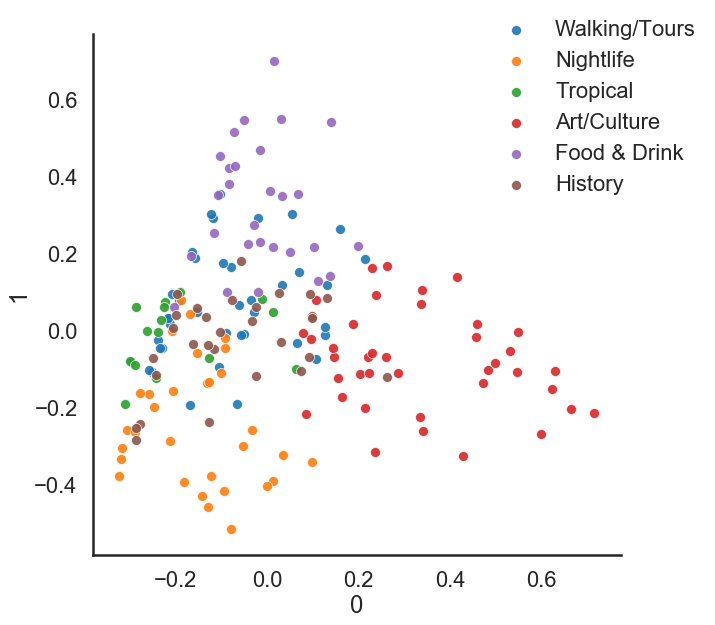

In [103]:
# Create scatter plots and highlight a couple of features
sns.set_style("white")
sns.set_context("poster")
six_topic_plot = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', height=9, plot_kws=dict(s=100, alpha=0.9));
six_topic_plot._legend.remove()
six_topic_plot.fig.legend(labels=topic_list, frameon=False);     

six_topic_plot.savefig('topic.png')

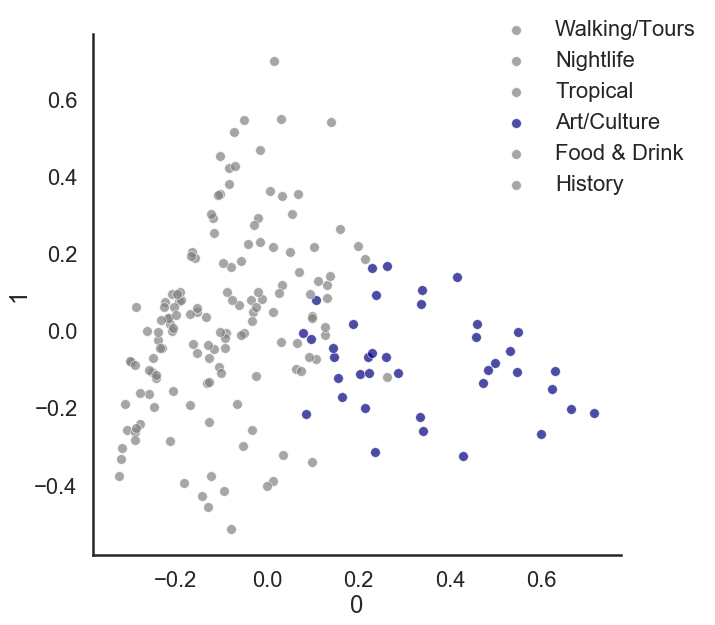

In [169]:
# Highlight art
sns.set_style("white")
sns.set_context("poster")
highlight_art = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', palette=['grey','grey','grey','navy','grey','grey'], height=9, plot_kws=dict(s=95, alpha=0.7));
highlight_art._legend.remove()
highlight_art.fig.legend(labels=topic_list, frameon=False);

highlight_art.savefig('art.png')
  

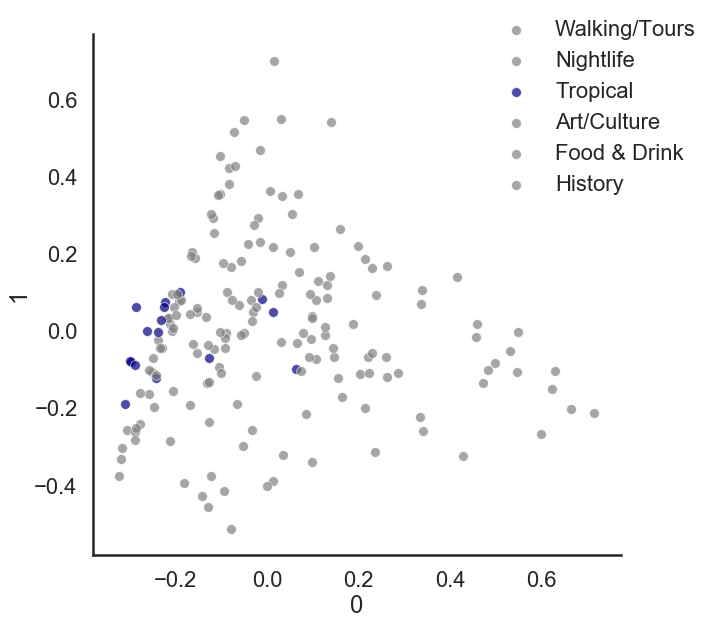

In [172]:
# Highlight Tropical
sns.set_style("white")
sns.set_context("poster")
highlight_trop = sns.pairplot(x_vars=[0], y_vars=[1], data=pca_df, hue='Topics', markers='o', palette=['grey','grey','navy','grey','grey','grey'], height=9, plot_kws=dict(s=95, alpha=0.7));
highlight_trop._legend.remove()
highlight_trop.fig.legend(labels=topic_list, frameon=False)

highlight_trop.savefig('trop.png');

## Recommender Engine

- Recommend based on topics - e.g. Rank which is most important & compare to topic distribution for each city

In [105]:
# Function to rank topics 
def rank(var_list):
    '''Takes a list of numbers and ranks them based on highest to lowest'''
    sorted_unique = sorted(set(var_list), reverse=True)
    order_dict = {val: i for i, val in enumerate(sorted_unique, 1)}
    return [order_dict[val] for val in var_list]

In [106]:
# Separate norm_df rows into lists
li = []
for i in range(0,len(norm_df)):
    df_list = list(norm_df.iloc[i])
    li.append(rank(df_list))   

In [108]:
# Create df with rankings of each topic for each country
ranked_df = pd.DataFrame(li, columns=topic_list, index=cities)
ranked_df.head()

,Walking/Tours,Nightlife,Tropical,Art/Culture,Food & Drink,History
Aarhus,3,5,4,1,2,5
Amsterdam,3,2,4,1,4,4
Anguilla,3,2,1,6,4,5
Antwerp,5,4,6,1,2,3
Aruba,2,2,1,2,2,2


In [113]:
# Test manually for flask app
walking_rank = int(input())
nightlife_rank = int(input())
tropical_rank = int(input())
art_rank = int(input())
fandd_rank = int(input())
history_rank = int(input())

6
4
2
1
3
5


In [114]:
inputs = {'Walking/Tours' : walking_rank, 
          'Nightlife':nightlife_rank, 
          'Tropical':tropical_rank, 
          'Art/Culture':art_rank, 
          'Food & Drink':fandd_rank, 
          'History':history_rank}

In [128]:
city_recommendations = recommendation(inputs)
correct_countries = return_countries(city_recommendations)
dict(zip(city_recommendations, correct_countries))

{'Copenhagen': 'Denmark', 'Lima': 'Peru', 'Helsinki': 'Finland'}